In [96]:
from typing import Callable
from functools import partial

import numpy as np
import pandas as pd
import scipy.odr as odr
import scipy.optimize as opt
import matplotlib.pyplot as plt
import uncertainties

from scipy.odr import ODR, Model, RealData
from scipy.optimize import brentq, minimize_scalar
from scipy.special import jn_zeros
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from adjustText import adjust_text
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator


In [97]:
import locale

mpl.rcParams.update({
    # --- FIGURA ---
    "figure.figsize": (8, 6),
    "figure.dpi": 120,

    # --- FUENTES Y TEXTO ---
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
    "text.latex.preamble": r"""
        \usepackage[utf8]{inputenc}
        \usepackage[T1]{fontenc}
        \usepackage{lmodern}
        \usepackage{amsmath}     % ✅ necesario para \dfrac
        \usepackage{nicefrac}
        \usepackage[version=4]{mhchem}
        \usepackage[spanish, es-tabla]{babel}
        \AtBeginDocument{%
          \mathcode`,="013B % coma decimal sin espacio en modo matemático
        }"""
	,
    # --- ETIQUETAS Y TÍTULOS ---
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "axes.edgecolor": "gray",
    "axes.linewidth": 1.2,
    'axes.formatter.use_locale': False,

    # --- TICKS ---
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 6,
    "ytick.major.size": 6,

    # --- LEYENDAS ---
    "legend.fontsize": 14,
    "legend.edgecolor": "gray",
    "legend.facecolor": "lightyellow",
    "legend.framealpha": 1.0,
    "legend.loc": "best",

    # --- GRILLA ---
    "grid.linestyle": ":",
    "grid.alpha": 0.6,
    "grid.color": "gray",

    # --- GUARDADO ---
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.1,
    "savefig.format": "pdf",
    "savefig.dpi": 300,
    "savefig.transparent": True,
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white",
})

locale.setlocale(locale.LC_NUMERIC, 'es_ES.UTF-8')  # o 'es_AR.UTF-8'

'es_ES.UTF-8'

In [98]:
# Constantes universales
hbar = 6.582119569e-16 # eV * s
c = 299792458 # m/s
m_e = 510.998e3 / c**2 # eV / c^2
q_e = 1.60217662e-19 # C
epsilon0 = 8.854187817e-12 # F/m

In [99]:
def swap_ev_and_nm(v: float) -> float:
    # Convert an energy in eV to a wavelength in nm, and vice-versa
    return 1240 / v

In [100]:
def load_data(url: str) -> pd.DataFrame: # str define que el tipo de variable que es url es una cadena de caracteres
  df = pd.read_csv(url, sep='\t', header=0)
  df['Wavelength unc'] = [0.001 for i in df['Wavelength nm.']] #df['nombre'] crea una nueva columna en el df cuyo encabezado es 'nombre'
  df['Wavelength w/unc'] = [uncertainties.ufloat(df['Wavelength nm.'][i], df['Wavelength unc'][i]) for i in range(len(df['Wavelength nm.']))]
  df[f'Abs. unc'] = [0.01 for i in df['Abs.']]
  df[f'Abs. w/unc'] = [uncertainties.ufloat(df['Abs.'][i], df['Abs. unc'][i]) for i in range(len(df['Abs.']))]
  return df.dropna()

def gaussiana(beta, x):
    # beta = [A, mu, sigma, offset]
    A, mu, s, offset = beta
    g = A * np.exp(- (x - mu)**2 / (2 * s**2)) + offset
    return g

def ajuste_ODR(x, y, errx, erry, beta0, func):
  model = Model(func)
  data = RealData(x, y, sx = errx, sy = erry)
  odr = ODR(data, model, beta0=beta0)
  out = odr.run()
  return out

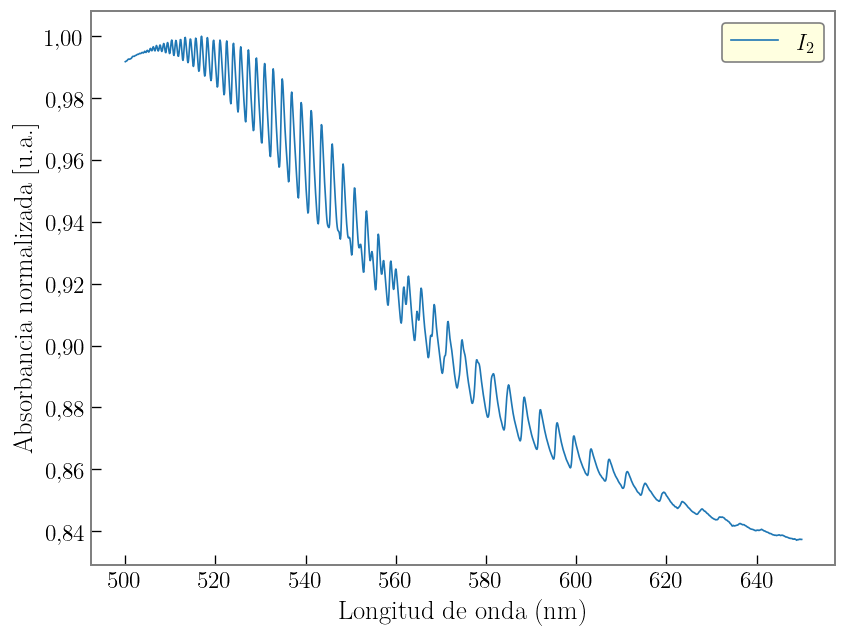

In [101]:
#open a .dat file and read it with pandas to convert it to a csv file

def read_dat_file(file_path):
    # Try reading with pandas read_csv, specifying space as a separator
    try:
        df = pd.read_csv(file_path, sep='\t', decimal=',')
        return df
    except Exception as e:
        print(f"Error reading with pandas: {e}")
        # Fallback to the original method if pandas read_csv fails,
        # but this will likely still have the column mismatch issue
        with open(file_path, 'r') as file:
            lines = file.readlines()
            header = lines[0].strip().split()
            data = [line.strip().split() for line in lines[1:]]
            df = pd.DataFrame(data, columns=header)
        return df

df_datosI2 = read_dat_file('DatosI2.dat')
#display(df_datosI2.head())
#convertir el df a un csv

df_datosI2.to_csv('datosI2.csv', index=False)
#abs = np.log(df_datosI2['1/T'])
abs_norm = df_datosI2['1/T']/df_datosI2['1/T'].max()
lambdas = df_datosI2['lambda']
#incerteza en la longitd de onda a partir de la diferencia entre dos puntos consecutivos
err_lambdas = np.diff(lambdas)
plt.plot(df_datosI2['lambda'], abs_norm, lw=1, label='$I_2$')
plt.xlabel('Longitud de onda (nm)')
plt.ylabel(r'Absorbancia normalizada [u.a.]')
plt.legend()
plt.show()


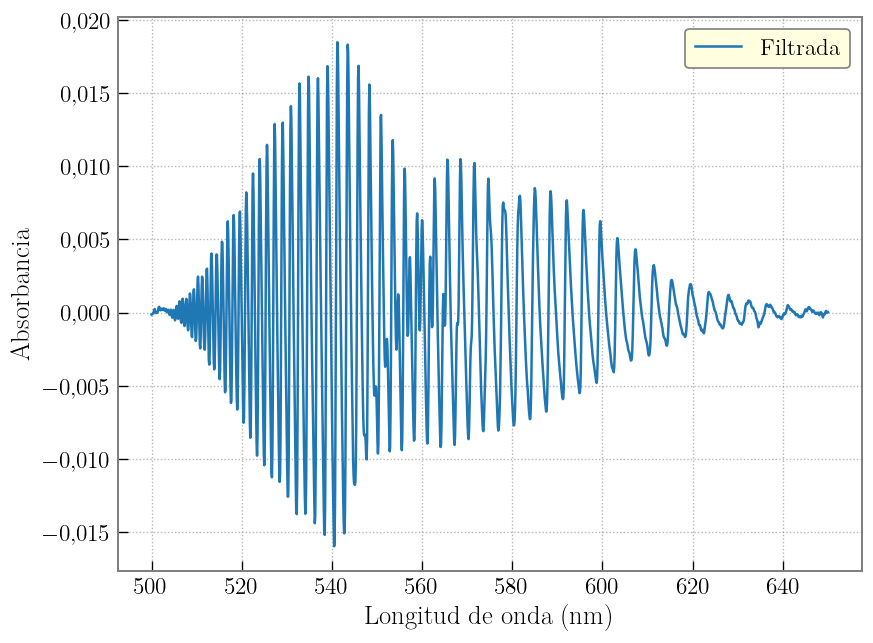

In [102]:
from scipy.signal import butter, filtfilt

# Diseñar filtro pasa alta
orden = 3
frecuencia_corte = 0.02
b, a = butter(orden, frecuencia_corte, btype='high', analog=False)

# Aplicar el filtro
abs_filtrada = filtfilt(b, a, abs_norm)

# Graficar
plt.figure()
#plt.plot(df_datosI2['lambda'], abs_norm, label='Original')
plt.plot(df_datosI2['lambda'], abs_filtrada, label='Filtrada', linestyle='-')
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia ")
plt.legend()
plt.grid()
plt.show()


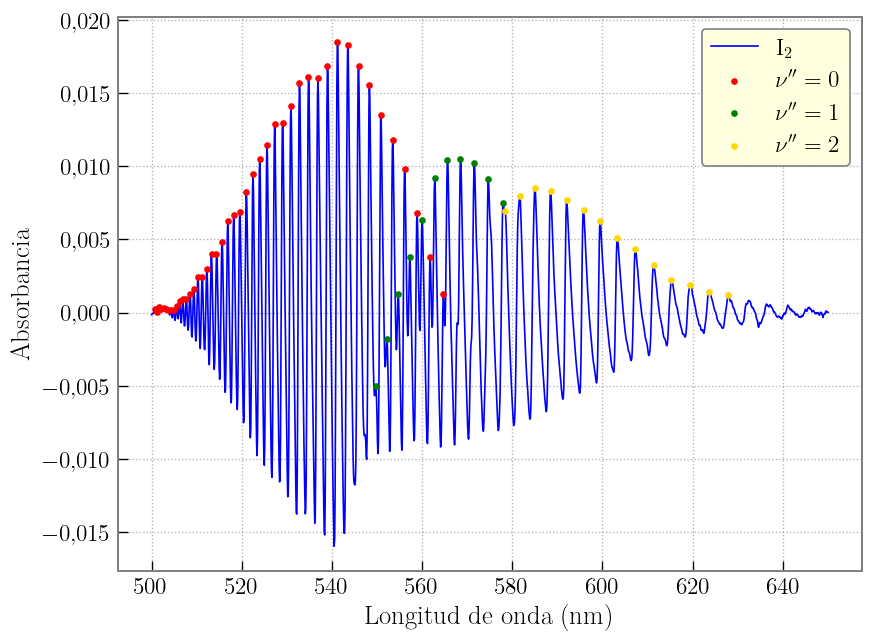

In [103]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

mask0 = df_datosI2['lambda'] < 565
mask1 = (df_datosI2['lambda'] > 548) & (df_datosI2['lambda'] < 580)
mask2 = (df_datosI2['lambda'] > 578) & (df_datosI2['lambda']<630)
lambdas_nu0 = df_datosI2['lambda'][mask0]  #longitudes de onda para la serie que parte de nu''=0
lambdas_nu1 = df_datosI2['lambda'][mask1]
lambdas_nu2 = df_datosI2['lambda'][mask2]
abs_nu0 = abs_filtrada[mask0]
abs_nu1 = abs_filtrada[mask1]
abs_nu2 = abs_filtrada[mask2]

def buscar_picos( y):
    peaks = find_peaks(y, height=-0.006)
    picos = peaks[0]
    lambdas = df_datosI2['lambda'][peaks[0]]
    return picos, lambdas

picos_nu0,lambdas_picos_nu0 = buscar_picos( abs_nu0)
picos_nu1,lambdas_picos_nu1 = buscar_picos( abs_nu1)
picos_nu2,lambdas_picos_nu2 = buscar_picos( abs_nu2)

picos_nu0 = np.delete(picos_nu0, [-2,-4,-6,-8,-8,-10,-12])
picos_nu1 = np.delete(picos_nu1, [0,2,4,6,8,10,12,14,-1])
picos_nu2 = np.delete(picos_nu2, [-1,-3,-5,-6,-8,-7,-10])


ancho_picos_nu0 = peak_widths(abs_nu0, picos_nu0, rel_height=0.5)
ancho_picos_nu1 = peak_widths(abs_nu1, picos_nu1, rel_height=0.5)
ancho_picos_nu2 = peak_widths(abs_nu2, picos_nu2, rel_height=0.5)



plt.plot(df_datosI2['lambda'], abs_filtrada, label='I$_2$', linestyle='-', color='blue' , lw=1)
#plt.plot(lambdas_nu0, abs_nu0, label=r'$\nu^{\prime\prime}=0$', c='red')
plt.scatter(lambdas_nu0.iloc[picos_nu0], abs_nu0[picos_nu0], color='red', label=r'$\nu^{\prime\prime}= 0$', zorder=100, marker='.')
#plt.plot(lambdas_nu1, abs_nu1, label=r'$\nu^{\prime\prime}=1$', c='blue')
plt.scatter(lambdas_nu1.iloc[picos_nu1], abs_nu1[picos_nu1], color='green', label=r'$\nu^{\prime\prime}= 1$ ', zorder=1000, marker='.')
#plt.plot(lambdas_nu2, abs_nu2, label=r'$\nu^{\prime\prime}=2$', c='green')
plt.scatter(lambdas_nu2.iloc[picos_nu2], abs_nu2[picos_nu2], color='gold', label=r'$\nu^{\prime\prime}=2$', zorder=10000, marker='.')
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia")
plt.grid()
plt.legend()
plt.show()

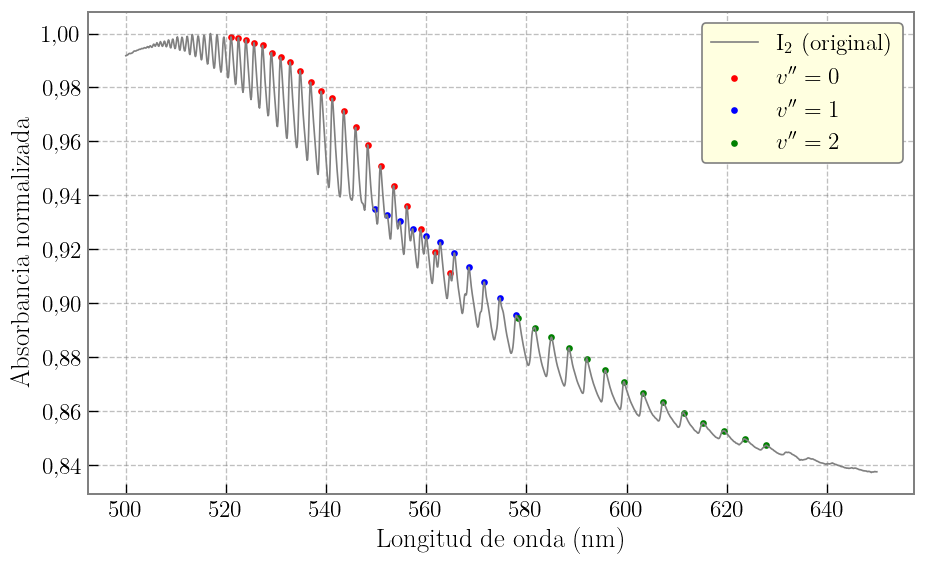

[ 9.07864034  9.09022218 10.10129369 11.10939546 11.12064516 11.12265302
 13.13331789 13.14693991 36.14934578 15.15196745 15.16004301 16.16769876
 16.15033383 18.13441803 19.12600021  5.00316614 19.11485495  6.00951365
 20.10590496  8.01889204 80.09502237  9.02682205 23.07761996 12.03764569
  4.02406791 13.09050736  2.00630451]


In [104]:

# --- Definición de máscaras ---
mask0 = (df_datosI2['lambda']>520) & (df_datosI2['lambda'] < 565)
mask1 = (df_datosI2['lambda'] > 548) & (df_datosI2['lambda'] < 580)
mask2 = (df_datosI2['lambda'] > 578) & (df_datosI2['lambda'] < 630)

# --- Subconjuntos filtrados ---
lambdas_nu0 = lambdas[mask0]
lambdas_nu1 = lambdas[mask1]
lambdas_nu2 = lambdas[mask2]
abs_nu0 = abs_filtrada[mask0]
abs_nu1 = abs_filtrada[mask1]
abs_nu2 = abs_filtrada[mask2]

def buscar_picos(y, lambdas):
    peaks, _ = find_peaks(y , height=-0.006)
    prominences, left_bases, right_bases = peak_prominences(y, peaks)
    prominence_data = (prominences, left_bases, right_bases)
    peaks_FMWS = peak_widths(lambdas, peaks, prominence_data = prominence_data, rel_height=0.5)
    return peaks, lambdas.iloc[peaks], peaks_FMWS[0]

# --- Picos en el espectro filtrado ---
picos_nu0, lambdas_picos_nu0, ancho_picos_nu0 = buscar_picos(abs_nu0, lambdas_nu0)
picos_nu1, lambdas_picos_nu1, ancho_picos_nu1 = buscar_picos(abs_nu1, lambdas_nu1)
picos_nu2, lambdas_picos_nu2, ancho_picos_nu2 = buscar_picos(abs_nu2, lambdas_nu2)

# --- Corrección manual ---
picos_nu0 = np.delete(picos_nu0, [-2, -4, -6, -8, -8, -10, -12])
picos_nu1 = np.delete(picos_nu1, [0, 2, 4, 6, 8, 10, 12, 14, -1])
picos_nu2 = np.delete(picos_nu2, [-1, -3, -5, -6, -8, -7, -10])

# --- Convertir a índices absolutos ---
idx_abs_nu0 = lambdas_nu0.index[picos_nu0]
idx_abs_nu1 = lambdas_nu1.index[picos_nu1]
idx_abs_nu2 = lambdas_nu2.index[picos_nu2]

# --- Graficar el espectro original con los mismos picos ---
plt.figure(figsize=(8,5))
plt.plot(lambdas, abs_norm, label=r'$\ce{I2}$ (original)', color='gray', lw=1)
plt.scatter(lambdas.loc[idx_abs_nu0][:], abs_norm.loc[idx_abs_nu0][:], color='red', label=r'$v^{\prime\prime}=0$', marker='.')
plt.scatter(lambdas.loc[idx_abs_nu1], abs_norm.loc[idx_abs_nu1], color='blue', label=r'$v^{\prime\prime}=1$', marker='.')
plt.scatter(lambdas.loc[idx_abs_nu2], abs_norm.loc[idx_abs_nu2], color='green', label=r'$v^{\prime\prime}=2$', marker='.')

plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia normalizada")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
print(ancho_picos_nu0)

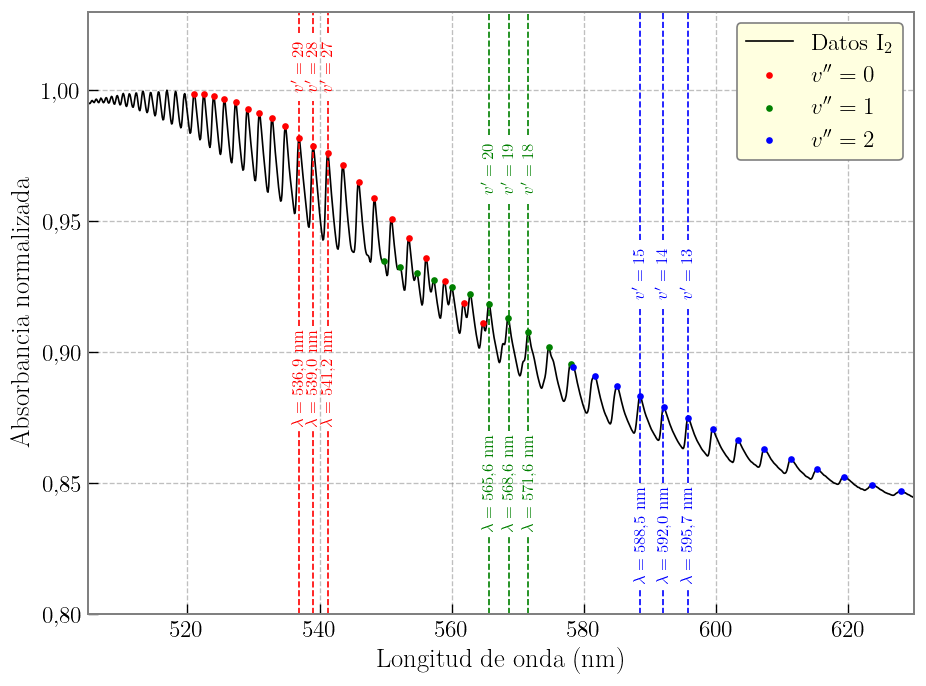

In [105]:
# --- Datos de líneas y etiquetas ---
lineas = [
    # ν'' = 0 (rojo)
    #{"lambda": 548.33, "color": "red", "nu": 24, "grupo": 0},
    {"lambda": 541.2,  "color": "red", "nu": 27, "grupo": 0},
    {"lambda": 539.0,  "color": "red", "nu": 28, "grupo": 0},
    {"lambda": 536.9,  "color": "red", "nu": 29, "grupo": 0},

    # ν'' = 1 (verde)
    {"lambda": 571.6, "color": "green", "nu": 18, "grupo": 1},
    {"lambda": 568.6, "color": "green", "nu": 19, "grupo": 1},
    {"lambda": 565.6, "color": "green", "nu": 20, "grupo": 1},

    # ν'' = 2 (amarillo)
    {"lambda": 595.7, "color": "blue", "nu": 13, "grupo": 2},
    {"lambda": 592.0, "color": "blue", "nu": 14, "grupo": 2},
    {"lambda": 588.5, "color": "blue", "nu": 15, "grupo": 2},
]

# --- Parámetros verticales ---
ymin, ymax = 0.8, 1.04
# altura de texto lambda y nu' para cada grupo
alturas_lambda = {0: 0.89, 1: 0.85, 2: 0.83}
alturas_nu =     {0: 0.999, 1: 0.96, 2: 0.92}
hueco_frac = 0.02  # fracción vertical que deja el espacio

# --- Graficar el espectro (como en tu código) ---
plt.plot(lambdas, abs_norm, label='Datos $\ce{I2}$', color='black', lw=1)

# Puntos de los tres grupos
plt.scatter(lambdas.loc[idx_abs_nu0][:], abs_norm.loc[idx_abs_nu0][:], zorder=10, color='red', label=r"$v''=0$", marker='.')
plt.scatter(lambdas.loc[idx_abs_nu1], abs_norm.loc[idx_abs_nu1], zorder=10, color='green', label=r"$v''=1$", marker='.')
plt.scatter(lambdas.loc[idx_abs_nu2], abs_norm.loc[idx_abs_nu2], zorder=10, color='blue', label=r"$v''=2$", marker='.')

# --- Dibujar líneas interrumpidas y textos ---
for l in lineas:
    x = l["lambda"]
    c = l["color"]
    g = l["grupo"]

    y_lambda = alturas_lambda[g]
    y_nu = alturas_nu[g]

    # Tramo inferior
    plt.vlines(x, ymin=ymin, ymax=y_lambda - hueco_frac, color=c, ls='--', lw=1)
    # Tramo medio
    plt.vlines(x, ymin = y_lambda + hueco_frac, ymax = y_nu - 0.003, color=c, ls='--', lw=1)
    # Tramo superior
    plt.vlines(x, ymin=y_nu + hueco_frac+ 0.003, ymax=ymax, color=c, ls='--', lw=1)

    # Texto de λ (en el hueco)
    plt.text(x, y_lambda, fr"$\lambda={x:.1f}$ nm",
             rotation=90, va='center', ha='center', color=c, fontsize=10)

    # Texto de ν′ (arriba del tramo superior)
    plt.text(x, y_nu, fr"$v'={l['nu']}$",
             rotation=90, va='bottom', ha='center', color=c, fontsize=10)
# --- Decoración general ---
plt.xlim(505 , 630)
plt.ylim(ymin, 1.03)
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Absorbancia normalizada")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('Espectro normalizado')
plt.show()

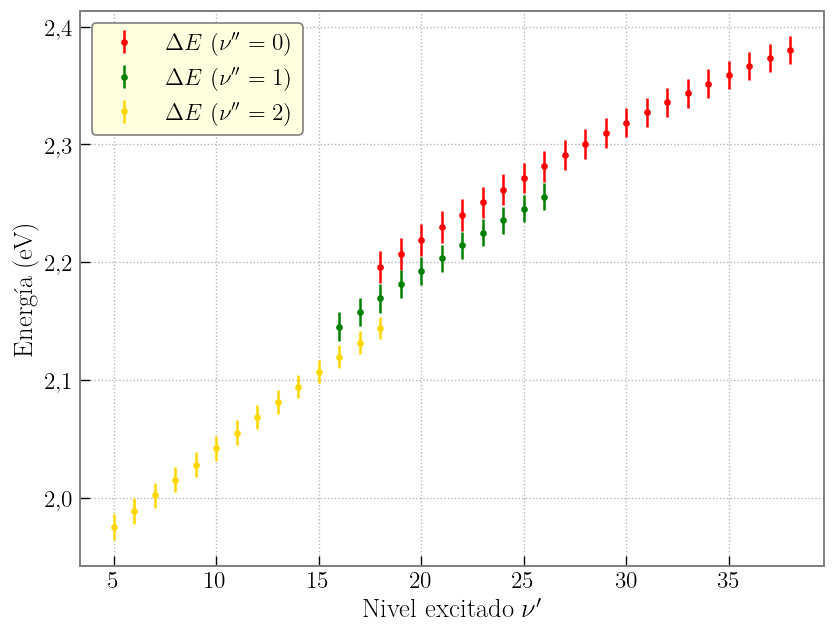

In [106]:
def negative_to_nan(v: float | np.ndarray) -> float | np.ndarray:
    '''
    Convierte valores negativos en np.nan.
    '''
    if isinstance(v, float):
        return np.nan if v < 0 else v
    elif isinstance(v, np.ndarray):
        arr = v.copy()
        arr[arr < 0] = np.nan
        return arr

#####
# función para hallar la posición del pico conocido
def buscar_indice(x,valor,tolerancia):
  indices = np.where(np.abs(x - valor) <= tolerancia)[0] #la posición en donde está el valor con 548.33
  return indices

#función para crear un arreglo con las posiciones y energias

def Nupp_energia(j_datos,j_conocido,x):
  n = len(x)
  Nu_pp = j_conocido - (np.arange(n) - j_datos)
  Energy=swap_ev_and_nm(x)
  err_Energy = swap_ev_and_nm(x-1.5)-swap_ev_and_nm(x+1.5)
  return negative_to_nan(np.column_stack((sorted(Nu_pp), sorted(Energy)))) , err_Energy
#####


#encontrar el pico en 548.33 nm y asignar el valor de la transición 0-->24

#en el set de picos asociados a nu0 determino cual de ellos es el valor con 548.33 nm
lambdasN0=np.array(lambdas_nu0.iloc[picos_nu0])
j = buscar_indice(lambdasN0,548.33,0.1)
nu0_pp_E , err_E_nu0  =Nupp_energia(j[0],24,lambdasN0)

#para la serie con nu''=1 utilizamos uno de los picos de la serie anterior que esté más cercano. Tomemos la transicion 0--> 20
lambdasN1=np.array(lambdas_nu1.iloc[picos_nu1])
k=buscar_indice(lambdasN1,565.6,0.1) #hay que ir jugando con la tolerancia
nu1_pp_E , err_E_nu1 = Nupp_energia(k[0],20,lambdasN1)


#para la serie con nu''=2 utilizamos el último pico de la serie nu''=1
lambdasN2=np.array(lambdas_nu2.iloc[picos_nu2])
l=buscar_indice(lambdasN2,588.5,0.5)
nu2_pp_E , err_E_nu2 = Nupp_energia(l[0],15,lambdasN2)



plt.errorbar(nu0_pp_E[:,0],nu0_pp_E[:,1], yerr = err_E_nu0 ,label=r'$\Delta E\,\,(\nu^{\prime\prime}=0)$',fmt='.', color='red')
plt.errorbar(nu1_pp_E[:,0],nu1_pp_E[:,1], yerr = err_E_nu1, label=r'$\Delta E\,\,(\nu^{\prime\prime}=1)$',fmt='.', color='green')
plt.errorbar(nu2_pp_E[:,0],nu2_pp_E[:,1], yerr = err_E_nu2, label=r'$\Delta E\,\,(\nu^{\prime\prime}=2)$', fmt='.', color='gold')

plt.xlabel(r"Nivel excitado $\nu^\prime$")
plt.ylabel("Energía (eV)")
plt.legend()
plt.grid()
plt.show()




Resultados del ajuste global:

a0 = 1.942152 ± 0.000924
a1 = 1.915893 ± 0.000901
a2 = 1.888955 ± 0.000650
b = 0.015877 ± 0.000069
C = -0.007327 ± 0.000059


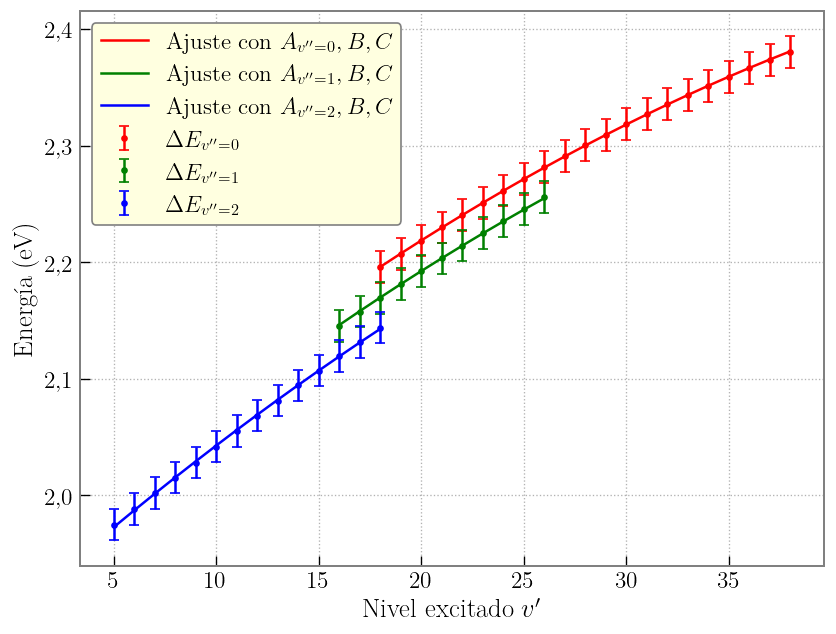

In [107]:
# --- Datos de entrada ---
y_nu0 = nu0_pp_E[:, 0]
y_nu1 = nu1_pp_E[:, 0]
y_nu2 = nu2_pp_E[:, 0]

x0, y0 = y_nu0, nu0_pp_E[:, 1]
x1, y1 = y_nu1, nu1_pp_E[:, 1]
x2, y2 = y_nu2, nu2_pp_E[:, 1]

# --- Concatenación de datos y etiquetas ---
x_all = np.concatenate([x0, x1, x2])
y_all = np.concatenate([y0, y1, y2])
erry_all = np.concatenate([err_E_nu0, err_E_nu1, err_E_nu2])

series_id = np.concatenate([
    np.full_like(x0, 0, dtype=int),
    np.full_like(x1, 1, dtype=int),
    np.full_like(x2, 2, dtype=int)
])

# --- Modelo combinado ---
def cuadratic_multiplo(xdata, a0, a1, a2, b, C):
    x, sid = xdata
    y = np.empty_like(x, dtype=float)
    y[sid == 0] = C*b*(x[sid == 0]+0.5)**2 + b*(x[sid == 0]+0.5) + a0 
    y[sid == 1] = C*b*(x[sid == 1]+0.5)**2 + b*(x[sid == 1]+0.5) + a1 
    y[sid == 2] = C*b*(x[sid == 2]+0.5)**2 + b*(x[sid == 2]+0.5) + a2 
    return y

# --- Ajuste global ---
p0 = [y0.min(), y1.min(), y2.min(), 0.1, 0.01]  # valores iniciales tentativos
popt, pcov = opt.curve_fit(cuadratic_multiplo, (x_all, series_id), y_all, sigma =erry_all,p0=p0)

# --- Resultados del ajuste ---
param_names = ['a0', 'a1', 'a2', 'b', 'C']
perr = np.sqrt(np.diag(pcov))  # incertezas 1σ

# Guardar parámetros e incertezas
params = dict(zip(param_names, popt))
errors = dict(zip([f"{n}_err" for n in param_names], perr))

# Mostrar resultados
print("Resultados del ajuste global:\n")
for n in param_names:
    print(f"{n} = {params[n]:.6f} ± {errors[f'{n}_err']:.6f}")

# --- Graficar ---
fig, ax = plt.subplots()
colors = ['red', 'green', 'blue']
for i, (x, y) in enumerate(zip([x0, x1, x2], [y0, y1, y2])):
    ai = params[f"a{i}"]
    ai_err = errors[f"a{i}_err"]
    y_fit = params["C"]*params["b"]*(x+0.5)**2 + params["b"]*(x+0.5) + ai
    ax.errorbar(x, y, yerr= erry_all[i], label=r'$\Delta E_{v^{\prime\prime}=}$'+f'$_{i}$', color = colors[i] , fmt='.', capsize=3)
    ax.plot(x, y_fit, label=r'Ajuste con $A_{v^{\prime\prime}=}$'+f'$_{i},\,B,\,C$', color = colors[i])

ax.set_xlabel(r"Nivel excitado $v^\prime$")
ax.set_ylabel("Energía (eV)")
ax.legend()
ax.grid()
plt.savefig('ajuste triple')
plt.show()




In [108]:
'''
# --- Datos de entrada ---
y_nu0 = nu0_pp_E[:, 0]
y_nu1 = nu1_pp_E[:, 0]
y_nu2 = nu2_pp_E[:, 0]

x0, y0 = y_nu0, nu0_pp_E[:, 1]
x1, y1 = y_nu1, nu1_pp_E[:, 1]
x2, y2 = y_nu2, nu2_pp_E[:, 1]

# --- Concatenación de datos y etiquetas ---
x_all = np.concatenate([x0, x1, x2])
y_all = np.concatenate([y0, y1, y2])
series_id = np.concatenate([
    np.full_like(x0, 0, dtype=int),
    np.full_like(x1, 1, dtype=int),
    np.full_like(x2, 2, dtype=int)
])

# --- Modelo combinado ---
def cuadratic_multiplo(xdata, a0, a1, a2, b, C, d):
    x, sid = xdata
    y = np.empty_like(x, dtype=float)
    y[sid == 0] = d*(x[sid == 0]+0.5)**3 + C*(x[sid == 0]+0.5)**2 + b*(x[sid == 0]+0.5) + a0
    y[sid == 1] = d*(x[sid == 1]+0.5)**3 + C*(x[sid == 1]+0.5)**2 + b*(x[sid == 1]+0.5) + a1
    y[sid == 2] = d*(x[sid == 2]+0.5)**3 + C*(x[sid == 2]+0.5)**2 + b*(x[sid == 2]+0.5) + a2
    return y

# --- Ajuste global ---
popt, pcov = opt.curve_fit(cuadratic_multiplo, (x_all, series_id), y_all , sigma=0.01)

# --- Resultados del ajuste ---
param_names = ['a0', 'a1', 'a2', 'b', 'C', 'd']
perr = np.sqrt(np.diag(pcov))  # incertezas 1σ

# Guardar parámetros e incertezas
params = dict(zip(param_names, popt))
errors = dict(zip([f"{n}_err" for n in param_names], perr))

# Mostrar resultados
print("Resultados del ajuste global:\n")
for n in param_names:
    print(f"{n} = {params[n]:.10f} ± {errors[f'{n}_err']:.10f}")

# --- Graficar ---
fig, ax = plt.subplots()
colors = ['red', 'green', 'gold']
for i, (x, y) in enumerate(zip([x0, x1, x2], [y0, y1, y2])):
    ai = params[f"a{i}"]
    ai_err = errors[f"a{i}_err"]
    y_fit = params["d"]*(x+0.5)**3+params["C"]*(x+0.5)**2 + params["b"]*(x+0.5) + ai
    ax.scatter(x, y, label=r'$\Delta E\,(\nu^{\prime\prime}$='+f'{i})', s=20, color = colors[i])
    ax.plot(x, y_fit, label=r'Ajuste con $a$'+f'$_{i}={ai:.3f}({ai_err*1000:.0f})$ eV', color = colors[i])

ax.set_xlabel(r"Nivel excitado $\nu^\prime$")
ax.set_ylabel("Energía (eV)")
ax.legend()
ax.grid()
plt.show()
'''

'\n# --- Datos de entrada ---\ny_nu0 = nu0_pp_E[:, 0]\ny_nu1 = nu1_pp_E[:, 0]\ny_nu2 = nu2_pp_E[:, 0]\n\nx0, y0 = y_nu0, nu0_pp_E[:, 1]\nx1, y1 = y_nu1, nu1_pp_E[:, 1]\nx2, y2 = y_nu2, nu2_pp_E[:, 1]\n\n# --- Concatenación de datos y etiquetas ---\nx_all = np.concatenate([x0, x1, x2])\ny_all = np.concatenate([y0, y1, y2])\nseries_id = np.concatenate([\n    np.full_like(x0, 0, dtype=int),\n    np.full_like(x1, 1, dtype=int),\n    np.full_like(x2, 2, dtype=int)\n])\n\n# --- Modelo combinado ---\ndef cuadratic_multiplo(xdata, a0, a1, a2, b, C, d):\n    x, sid = xdata\n    y = np.empty_like(x, dtype=float)\n    y[sid == 0] = d*(x[sid == 0]+0.5)**3 + C*(x[sid == 0]+0.5)**2 + b*(x[sid == 0]+0.5) + a0\n    y[sid == 1] = d*(x[sid == 1]+0.5)**3 + C*(x[sid == 1]+0.5)**2 + b*(x[sid == 1]+0.5) + a1\n    y[sid == 2] = d*(x[sid == 2]+0.5)**3 + C*(x[sid == 2]+0.5)**2 + b*(x[sid == 2]+0.5) + a2\n    return y\n\n# --- Ajuste global ---\npopt, pcov = opt.curve_fit(cuadratic_multiplo, (x_all, series_id),

In [109]:
def swap_ev_to_cm1(x):
    """
    Convertir energía en eV a número de onda en cm⁻¹.
    """
    hbar = 6.582119569e-16  # eV·s
    c = 2.99792458e8         # m/s
    
    x = np.array(x, dtype=float)  # convierte a array numérico
    return x / (2 * np.pi * hbar * c * 1e2)


def swap_cm1_to_ev(x: float | np.ndarray):
    '''
    Convertir número de onda en cm⁻¹ a energía en eV.
    x : float | np.ndarray
    NOTA: hbar tiene que estar en eV*s y c en m/s
    '''
    x = np.array(x , dtype=float)
    return x * (2*np.pi*hbar*c*1e2)

In [110]:
hw_1 = float(params['b'])   #hbar*omega' en eV
hXw_1 = -float(params['C']*params['b']) #hbar*omega'*X' en eV

hw_1_cm1 = swap_ev_to_cm1(hw_1)
hXw_1_cm1 = swap_ev_to_cm1(hXw_1)

err_hw_1_cm1 = swap_ev_to_cm1(errors['b_err'])
err_hXw_1_cm1 = swap_ev_to_cm1(errors['C_err'])

print(f'omega prima:  {hw_1_cm1:.6f} +/- {err_hw_1_cm1} cm^-1' )
print(f'chi omega prima: {hXw_1_cm1:.6f} +/- {err_hXw_1_cm1} cm^-1')

wp_ref=129.8 #cm^-1
weXe_ref=0.985 #cm^-1

omega prima:  128.060311 +/- 0.5529036642151585 cm^-1
chi omega prima: 0.938282 +/- 0.47244903046220127 cm^-1


In [117]:
#sistema de ecuaciónes para hallar wp, weXep y De a partir de a

def solve_3x3_diagnose(A, b, tol_det=1e-12, cond_warn=1e8, cond_bad=1e12):
    A = np.array(A, dtype=float).reshape(3,3)
    b = np.array(b, dtype=float).reshape(3,)

    det = np.linalg.det(A)
    cond = np.linalg.cond(A)
    rankA = np.linalg.matrix_rank(A)
    # construir matriz aumentada y su rango
    A_aug = np.column_stack([A, b])
    rankAug = np.linalg.matrix_rank(A_aug)

    info = {
        'det': det,
        'cond': cond,
        'rankA': rankA,
        'rankAug': rankAug,
        'status': None,
        'method': None,
        'x': None
    }

    # Diagnóstico
    if rankA != rankAug:
        info['status'] = 'incompatible'   # no hay solución
        return info

    if rankA == 3:
        # potencial solución única (revisar condicionamiento numérico)
        if abs(det) < tol_det or cond >= cond_bad:
            info['status'] = 'singular_o_mal_condicionada'
            info['method'] = 'pinv (pseudoinversa) como fallback'
            info['x'] = np.linalg.pinv(A) @ b
            return info
        elif cond >= cond_warn:
            info['status'] = 'bien_condicionada_con_precaucion'
            info['method'] = 'solve (advertencia sobre cond)'
            info['x'] = np.linalg.solve(A, b)
            return info
        else:
            info['status'] = 'solucion_unica'
            info['method'] = 'solve'
            info['x'] = np.linalg.solve(A, b)
            return info

    # rankA < 3 y rankA == rankAug -> infinitas soluciones
    info['status'] = 'infinitas_soluciones'
    # provide a particular solution via least squares / pseudoinverse
    info['method'] = 'lstsq/pinv (particular) y nullspace para la homogénea'
    info['x_particular'], residuals, rnk, s = np.linalg.lstsq(A, b, rcond=None)
    # nullspace via SVD:
    U, S, Vt = np.linalg.svd(A)
    null_mask = (S <= 1e-12)
    # For 3x3, easier to compute nullspace directly:
    # The nullspace dimension = 3 - rankA
    # Use pseudoinverse to show one particular solution
    info['x'] = info['x_particular']
    return info

A = np.array([[1, -0.5, 0.25],
              [1, -1.5, 2.25],
              [1, -2.5, 6.25]],dtype=float)
solution = solve_3x3_diagnose(A, (params['a0'],params['a1'],params['a2']))
sol = solution['x']

Delta_E = sol[0] # energía de transición electrónica en eV
hw_0 = sol[1] # hbar * omega'' en eV
hXw_0 = sol[2] #habr * chi'' * omega'' en eV


Delta_E_cm1 = swap_ev_to_cm1(Delta_E)
hw_0_cm1 = swap_ev_to_cm1(hw_0)
hXw_0_cm1 = swap_ev_to_cm1(hXw_0)

err_Delta_E_cm1 = np.sqrt(((15/8)*swap_ev_to_cm1(errors['a0_err']))**2 + ((5/4)*swap_ev_to_cm1(errors['a1_err']))**2 + ((3/8)*swap_ev_to_cm1(errors['a2_err'])**2))
err_hw_0_cm1 = np.sqrt((2*swap_ev_to_cm1(errors['a0_err']))**2 + (3*swap_ev_to_cm1(errors['a1_err']))**2 + (swap_ev_to_cm1(errors['a2_err']))**2)
err_hXw_0_cm1 = np.sqrt((swap_ev_to_cm1(errors['a0_err']))**2 + (2*swap_ev_to_cm1(errors['a1_err']))**2 + (swap_ev_to_cm1(errors['a2_err']))**2)/2


print(f'Delta E {Delta_E_cm1} +/- {err_Delta_E_cm1} cm^-1')
print(f'omega 2prima: {hw_0_cm1} +/- {err_hw_0_cm1} cm^-1')
print(f'chi omega 2prima: {hXw_0_cm1} +/- {err_hXw_0_cm1} cm^-1')

print(swap_ev_to_cm1(params['a0']))
print(swap_ev_to_cm1(errors['a0_err']))

Delta E 16368.31058501065 +/- 60.187307015177225 cm^-1
omega 2prima: 729.5653181032293 +/- 102.57167932345745 cm^-1
chi omega 2prima: 138.32752503673453 +/- 33.032280095981896 cm^-1
16038.109807218218
24.802035729439556


alpha_0= 0.7257393500534473 +/- 0.15754631841332478
alpha_1= 1.8788124540474804 +/- 0.4731540146960518
De_0= 76005.1292076703 +/- 26369.86716413139
De_1= 4369.5383970942 +/- 2200.49720430942
9.423435020896004
0.5417537156449156


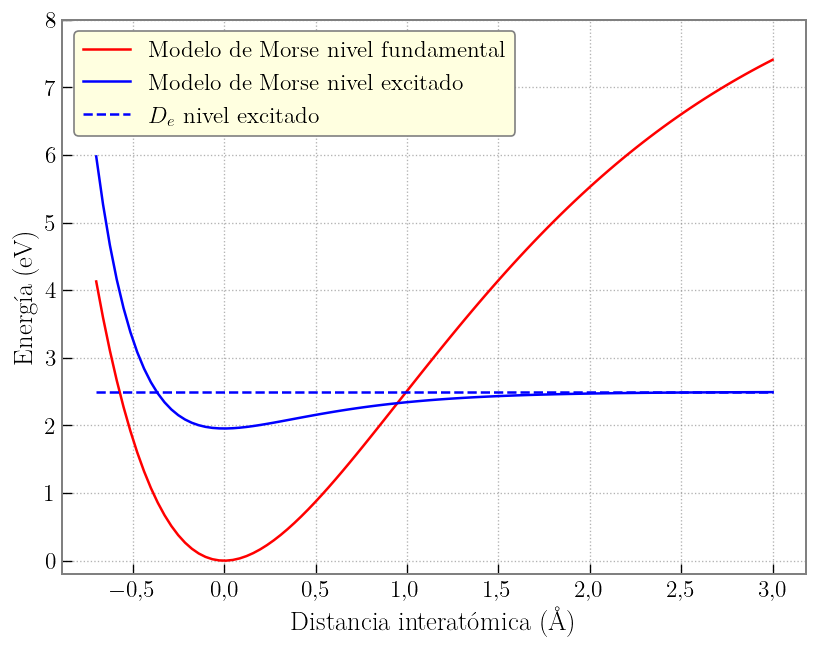

In [112]:
#masa reducida del yodo 
m=(0.5*2.11*1e-25)
c = 2.99792458e8
hbar_si= (6.0262607015e-34)
De_0 = (hw_0_cm1**2) / (4*0.14) #Energía de disociación del nivel fundamental
err_De_0 = np.sqrt(((hw_0_cm1*err_hw_0_cm1)/(2*0.14))**2+((0.032*hw_0_cm1**2)/(4*0.14**2))**2)
De_1 = (hw_1_cm1**2) / (4*hXw_1_cm1) #Energía de disociación del nivel excitado
err_De_1 = np.sqrt(((hw_1_cm1*err_hw_1_cm1)/(2*hXw_1_cm1))**2+((hw_1_cm1**2*err_hXw_1_cm1)/(4*hXw_1_cm1**2))**2)

#alpha_0=(np.sqrt((2*m*c)/(De_0*hbar_si*1e4))*0.14*np.pi)*1e-7
#err_alpha_0=(np.pi*np.sqrt(2*m*c/hbar_si))*np.sqrt((1e-7*0.032/np.sqrt(De_0*1e4))**2 + (1e-7*0.14*err_De_0/(2*1e4*De_0**(3/2)))**2)
#alpha_1=(np.sqrt((2*c*m)/(De_1*hbar_si*1e4))*hw_1_cm1*np.pi)*1e-7
#err_alpha_1=(np.pi*np.sqrt(2*m*c/hbar_si))*np.sqrt((1e-7*err_hw_1_cm1/np.sqrt(De_1*1e4))**2 + (1e-7*hw_1_cm1*err_De_1/(2*1e4*De_1**(3/2)))**2)

#las unidades son un problema, para evitarlo, de la referencia obtuve que la relación para alpha es a=(0.9698)*w/\sqrt(De) y obtenemos en Angstroms^-1
alpha_0=(0.96981)*hw_0_cm1/np.sqrt(De_0)
err_alpha_0= (0.96981)*np.sqrt( (err_hw_0_cm1/np.sqrt(De_0))**2 + ((hw_0_cm1*err_De_0/(2*De_0**(3/2)))**2 )) 
alpha_1=(0.96981)*hw_1_cm1/np.sqrt(De_1)
err_alpha_1= (0.96981)*np.sqrt( (err_hw_1_cm1/np.sqrt(De_1))**2 + ((hw_1_cm1*err_De_1/(2*De_1**(3/2)))**2 ))

print('alpha_0=',alpha_0, '+/-',err_alpha_0)
print('alpha_1=',alpha_1, '+/-',err_alpha_1)
print('De_0=',De_0, '+/-',err_De_0)
print('De_1=',De_1, '+/-',err_De_1)

print(swap_cm1_to_ev(De_0))
print(swap_cm1_to_ev(De_1))

#modelo de Morse con los parámetros obtenidos vs los datos experimentales
def modelo_morse(r,De, alpha,Delta_E_elec):
    return De * (1 - np.exp(-alpha*r))**2+ Delta_E_elec

r=np.linspace(-0.7,3,100) # distancia interatómica en angstroms


plt.plot(r, modelo_morse(r, swap_cm1_to_ev(De_0), alpha_0,0), label='Modelo de Morse nivel fundamental', color='red')
plt.plot(r, modelo_morse(r, swap_cm1_to_ev(De_1),alpha_1,Delta_E), label='Modelo de Morse nivel excitado', color='blue')
#plt.hlines(swap_cm1_to_ev(De_0), xmin=-0.7, xmax=3, colors='red', linestyles='--', label=r'$D_e$ nivel fundamental')
plt.hlines(swap_cm1_to_ev(De_1)+Delta_E, xmin=-0.7, xmax=3, colors='blue', linestyles='--', label=r'$D_e$ nivel excitado')
plt.xlabel('Distancia interatómica (Å)')
plt.ylabel('Energía (eV)')
plt.ylim(-0.2,8)
plt.legend()
plt.grid()
plt.show()






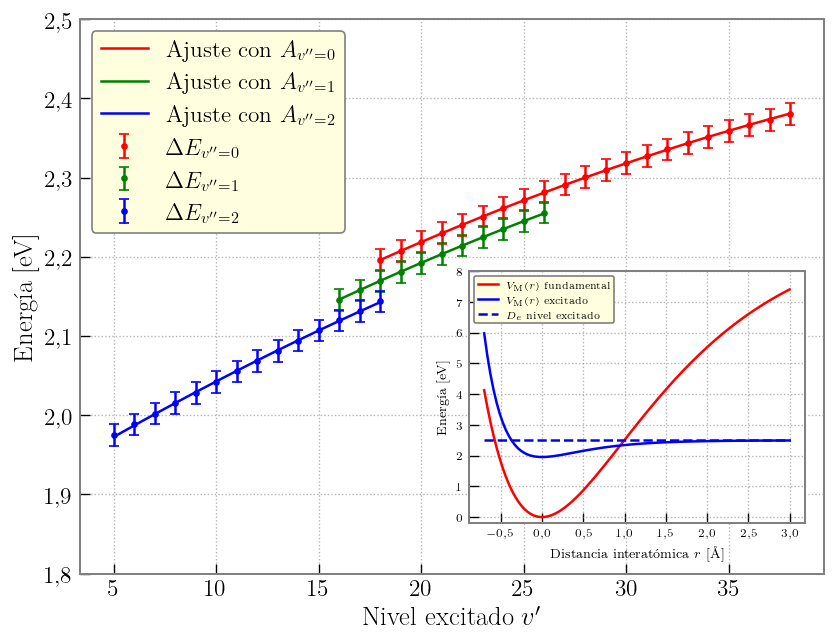

In [113]:

# --- Gráfico principal ---
fig, ax = plt.subplots()
colors = ['red', 'green', 'blue']

for i, (x, y) in enumerate(zip([x0, x1, x2], [y0, y1, y2])):
    ai = params[f"a{i}"]
    ai_err = errors[f"a{i}_err"]
    y_fit = params["C"]*params["b"]*(x+0.5)**2 + params["b"]*(x+0.5) + ai
    ax.errorbar(x, y, yerr=erry_all[i],
                label=rf'$\Delta E_{{v^{{\prime\prime}}={i}}}$',
                color=colors[i], fmt='.', capsize=3)
    ax.plot(x, y_fit,
            label=rf'Ajuste con $A_{{v^{{\prime\prime}}={i}}}$',
            color=colors[i])

ax.set_xlabel(r"Nivel excitado $v^\prime$")
ax.set_ylabel("Energía [eV]")
ax.legend()
ax.set_ylim(2-0.2, 2.5)
ax.grid()

# --- Gráfico dentro del principal ---
# Coordenadas [x0, y0, ancho, alto] en fracción del tamaño del eje principal
inset_ax = fig.add_axes([0.53, 0.18, 0.35, 0.35])  # mueve o ajusta estos valores a gusto

inset_ax.plot(r, modelo_morse(r, swap_cm1_to_ev(De_0), alpha_0, 0),
              label=r'$V_\mathrm{M}(r)$ fundamental', color='red')
inset_ax.plot(r, modelo_morse(r, swap_cm1_to_ev(De_1), alpha_1, Delta_E),
              label=r'$V_\mathrm{M}(r)$ excitado', color='blue')
inset_ax.hlines(swap_cm1_to_ev(De_1)+Delta_E, xmin=-0.7, xmax=3,
                colors='blue', linestyles='--', label=r'$D_e$ nivel excitado')

inset_ax.set_xlabel(r'Distancia interatómica $r$ [Å]', fontsize=8)
inset_ax.set_ylabel('Energía [eV]', fontsize=8)
inset_ax.tick_params(axis='both', labelsize=7)
inset_ax.set_ylim(-0.2, 8)
inset_ax.grid(True)
inset_ax.legend(fontsize=6)

plt.savefig('ajuste_triple_con_inset.pdf', bbox_inches='tight')

plt.show()

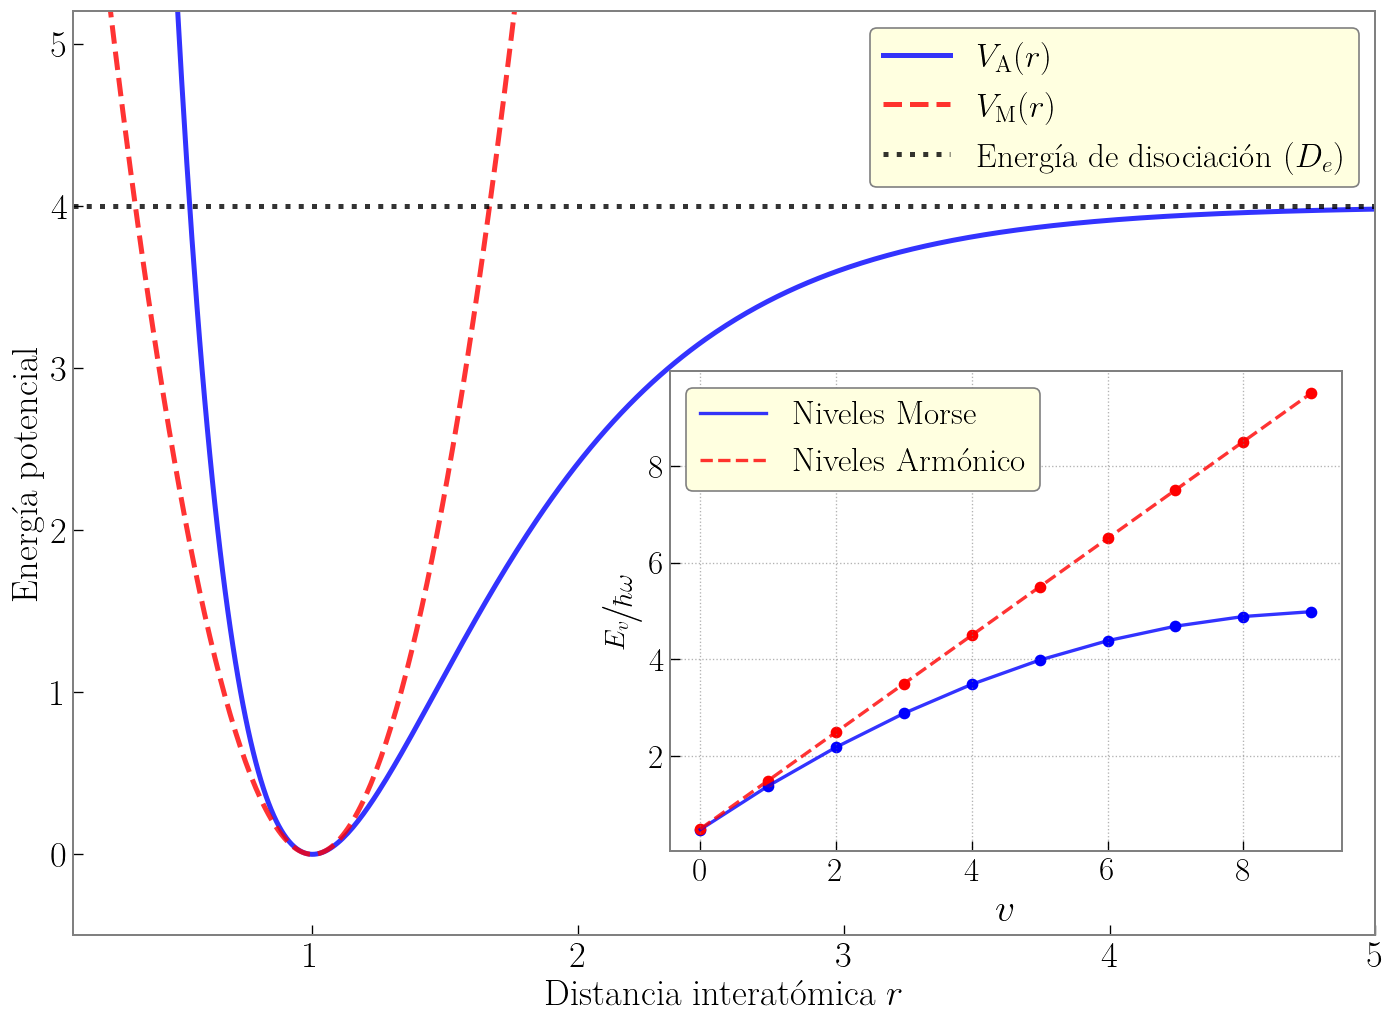

In [114]:
# Parámetros del potencial de Morse (ejemplo para molécula diatómica)
D_e = 4.0  # Energía de disociación (eV)
a = 1.5    # Parámetro de ancho del pozo
r_e = 1.0  # Posición de equilibrio (Å)
mu = 1.0   # Masa reducida (uma)

# Constante de fuerza para el oscilador armónico (calculada a partir de Morse)
k = 2 * D_e * a**2  # Constante de fuerza

# Función del potencial de Morse
def morse_potential(r):
    return D_e * (1 - np.exp(-a * (r - r_e)))**2

# Función del potencial armónico
def harmonic_potential(r):
    return 0.5 * k * (r - r_e)**2


# Rango de distancias
r = np.linspace(0.2, 5, 500)

# Calcular potenciales
V_morse = morse_potential(r)
V_harmonic = harmonic_potential(r)

# Crear la figura
fig, ax = plt.subplots(figsize=(14, 10))

# Graficar los potenciales
ax.plot(r, V_morse, 'b-', linewidth=3, label=r'$V_\mathrm{A}(r)$', alpha=0.8)
ax.plot(r, V_harmonic, 'r--', linewidth=3, label=r'$V_\mathrm{M}(r)$', alpha=0.8)


# Línea de energía de disociación
ax.axhline(y=D_e, color='black', linestyle=':', linewidth=3,
           label=r'Energía de disociación ($D_e$)', alpha=0.8)


# Personalizar el gráfico
ax.tick_params(labelsize=22)
ax.set_xlabel(r'Distancia interatómica $r$', fontsize = 22)
ax.set_ylabel('Energía potencial', fontsize = 22)


# Límites del gráfico
ax.set_ylim(-0.5, D_e + 1.2)
ax.set_xlim(0.1, 5)

# Leyenda
ax.legend(loc='upper right', fontsize=20)


inset_ax = fig.add_axes([0.48, 0.18, 0.4, 0.4])

n=np.arange(0,10,1)
En_armonico=n+0.5
En_morse= (n+0.5) - 0.05*(n+0.5)**2

inset_ax.plot(n, En_morse, 'b-', linewidth=2, label='Niveles Morse', alpha=0.8)
inset_ax.scatter(n, En_morse, color='blue')
inset_ax.plot(n, En_armonico, 'r--', linewidth=2, label='Niveles Armónico', alpha=0.8)
inset_ax.scatter(n, En_armonico, color='red')
inset_ax.set_xlabel(f'$v$', fontsize=24)
inset_ax.set_ylabel(r'$\nicefrac{E_v}{\hbar\omega}$', fontsize=24)
inset_ax.tick_params(labelsize = 20)
inset_ax.legend(fontsize = 20)
plt.grid()
plt.savefig('potenciales.pdf')
plt.show()

